In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')
df_test = pd.read_csv('/content/sample_data/mnist_test.csv')

df_train = df_train.head(1000)
x_tr = df_train.to_numpy()
y_train = x_tr[:, 0]
x_train = x_tr[:, 1:]

df_test = df_test.head(200)
x_te = df_test.to_numpy()
y_test = x_te[:, 0]
x_test = x_te[:, 1:]

#feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

#PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
train_pca = pca.fit_transform(x_train, y_train)
test_pca = pca.fit_transform(x_test, y_test)

In [39]:
def get_acc(clusters_pr, y_train):
  n_train = len(set(y_train))
  currect_pr = 0

  for clu in set(clusters_pr):
    xs_in_group = [0 for _ in range(n_train+1)]
    for i in range(len(clusters_pr)):
      if clusters_pr[i]==clu:
        xs_in_group[y_train[i]] += 1
    predicted_group = np.argmax(xs_in_group)  
    for j in range(len(clusters_pr)):
      if clusters_pr[j]==clu and clusters_pr[j]==predicted_group:
        currect_pr+=1

  return currect_pr/len(clusters_pr)

#print(get_acc([1,2,2,2,1,1,1,3], [1,1,2,2,1,1,1,3]))

In [35]:
#PCA -> DBSCAN
from sklearn.cluster import DBSCAN
eps_counter = np.arange(0.6, 4, 0.05)
ms_counter = [3,4,5,6,7,8,9,10,11]
max_acc = 0
max_ms = 0
max_eps = 0
for ep in eps_counter:
  for ms in ms_counter:
    db = DBSCAN(eps=ep, min_samples=ms)
    db = db.fit(train_pca)
    labels_db = db.labels_
    clusters_db = db.fit_predict(test_pca)
    acc = get_acc(clusters_db, y_test)
    n_clusters_ = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
    n_noise_ = list(clusters_db).count(-1)
    if acc > max_acc and n_clusters_ >= 10 and n_noise_ < len(y_test)/3:
      max_acc = acc
      max_ms = db.min_samples
      max_eps = db.eps
      max_noise = n_noise_
      max_clusters = n_clusters_
    #print ("min sample: {}\teps:{}\tcluster: {}\tnoise points:{}\tacc:{}" .format(ms, ep, n_clusters_ ,n_noise_, acc))
print("max acc: {}\teps: {}\tmin samples:{}\tcluster: {}\tnoise points:{}" .format(max_acc, max_eps, max_ms, max_clusters ,max_noise))

max acc: 0.255	eps: 1.1500000000000004	min samples:3	cluster: 11	noise points:47


In [36]:
db = DBSCAN(eps=0.95, min_samples=3)
print(db.fit_predict(test_pca))

[-1  0 -1 -1  0  1 -1 -1  1 -1 10  2 -1  0 -1 -1  2 -1  2  3  4 -1  5  2
 -1  6 -1 10  0  4  3  4 -1  5 -1  2  0 -1  0  0  7  2  4  8  4  3  5 -1
 11  4 -1  5  4  9  4 -1  0 -1  3 -1 10  7  4  1  3 -1 11  4 -1  2 -1 -1
 -1  0 -1 -1  5  3  1  6  4 12  6  1 -1  3  4 -1  0  4  5  3 -1  0 -1  3
  4 -1 -1  4 -1  1 -1 -1 -1 -1  8  2 -1  4  0  8 -1  3  3  7 11  7  1 -1
  5  7  4  2  7  9  5  1  5  4 -1 12  1  5  0 -1 -1 -1  1  4 -1  5  0  7
  0  5  9 -1  4 -1 -1  5  4  0  4 -1 -1  4  3  2 -1 -1 -1  5 12  1  5  0
  2  2  5 -1  4  4  3  0 -1  0  4  0  4  3 -1  4  2 -1 -1 -1  3  0  3 -1
  2 -1  3  0  4  2 -1 -1]


In [37]:
#PCA -> k-MEANS
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, random_state=0)
km = km.fit(train_pca)
labels_km = km.labels_
clusters_km = km.predict(test_pca)
n_noise_ = list(clusters_km).count(-1)
acc = get_acc(clusters_km, y_test)
print(clusters_km)
print(y_test)
print('Estimated number of clusters in pca-KM: %d' %10)
print('Estimated number of noise points in KM: %d' % n_noise_)
print('Accuracy of KM: %d' %acc)

[6 4 0 7 4 5 5 0 5 2 0 5 0 4 6 7 5 6 5 4 9 9 9 5 8 7 7 0 4 1 4 1 0 9 2 7 4
 6 4 4 5 5 1 1 1 4 9 7 7 1 6 9 9 8 9 7 4 7 4 7 0 5 1 7 4 9 7 1 8 5 8 6 4 4
 5 1 5 4 5 5 9 6 7 9 3 4 9 0 1 1 9 4 1 4 7 4 1 9 7 9 0 9 3 7 7 2 1 5 5 1 4
 1 5 4 4 5 7 5 9 0 9 5 9 5 5 8 9 9 9 9 6 6 5 9 1 9 1 0 5 1 7 9 4 5 4 9 8 6
 1 7 7 9 1 4 9 9 9 6 4 5 6 0 3 9 6 5 9 4 5 5 9 6 1 1 4 4 9 4 1 4 1 4 8 1 5
 6 9 2 4 4 4 2 5 0 4 1 1 5 6 2]
[2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1
 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9 1
 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8 7
 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2 0
 2 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 7 1 8 1 8 1 8 5 0 8 9
 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3]
Estimated number of clusters in pca-KM: 10
Estimated number of noise points in KM: 0
Accuracy of KM: 0


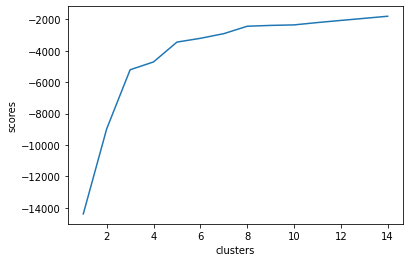

In [38]:
#elbow method
clusters = []
scores = []
for i in range(1, 15):
  km = KMeans(n_clusters=i, random_state=0)
  km = km.fit(train_pca)
  labels_km = km.labels_
  clusters_km = km.predict(test_pca)
  n_noise_ = list(clusters_km).count(-1)
  scores.append(km.score(test_pca))
  clusters.append(i)
plt.plot(clusters, scores)
plt.ylabel("scores")
plt.xlabel("clusters")
plt.show()